# Random Forests

As we saw earlier, polynomial feature extraction and doing liner regression and Kernel Ridge have their limitations.

Another more useful approach is to use a Random Forest regression - this of this as a regression algorithm that creates multiple estimators for the data, each estimator minimizing the error, and then the prediction is based on the estimator for the given input conditions.

Lets see an example

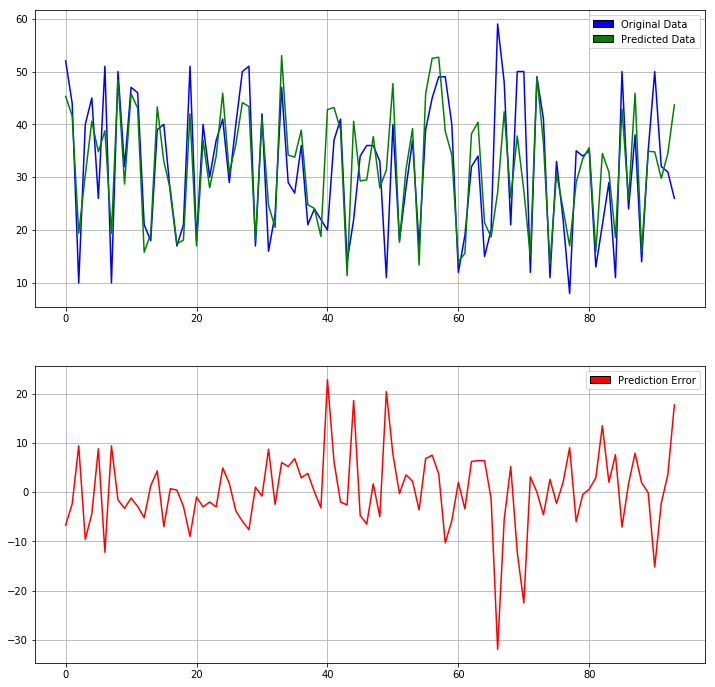

In [1]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sgtaxidata import *

DBNAME="../taxis.db"
DATE="20170627"
LOC="Sengkang"

lat,lon=utils.get_lat_long(LOC)

df=taxis.getdf_loc_date(DBNAME,DATE,lat,lon)

X=df.drop(['TaxiCount'],axis=1).as_matrix()
y=np.array(df['TaxiCount']).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train.ravel())

visualize.plot_model(X_test,y_test.ravel(),model)

At first look the error seems to be lesser than the Kernel Ridge, lets check by scoring

In [2]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
import math

print "Score for test data : ",model.score(X_test,y_test)
print "Score for training data : ",model.score(X_train,y_train)

print "Mean absolute error of prediction : ",mean_absolute_error(y_test,model.predict(X_test))
print "Mean square error of prediction : ",mean_squared_error(y_test,model.predict(X_test))
print "Mean square deviation of prediction : ",math.sqrt(mean_squared_error(y_test,model.predict(X_test)))

Score for test data :  0.623505376476
Score for training data :  0.948113241937
Mean absolute error of prediction :  5.69893617021
Mean square error of prediction :  62.6915957447
Mean square deviation of prediction :  7.91780245679


We see that the training data fits more accurately, and we get a 60% accuracy on prediction for the test data. This is marginally better than the previous kernel ridge.

Random forest generally has less parameters to control than the other approaches, however it has a parameter which helps us to train it with incremental data. Its called warm_start and this tells the estimator to learn on top of the last iteration.

Lets try this for a few dates.

In [3]:
DATE1='20170628'
df1=taxis.getdf_loc_date(DBNAME,DATE1,lat,lon)

X1=df1.drop(['TaxiCount'],axis=1)
y1=np.array(df1['TaxiCount'])

model1 = RandomForestRegressor(warm_start=True)
#fit the first full day data
model1.fit(X, y.ravel())
#add more estimators
model1.n_estimators+=10
model1.fit(X1,y1.ravel())

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=True)

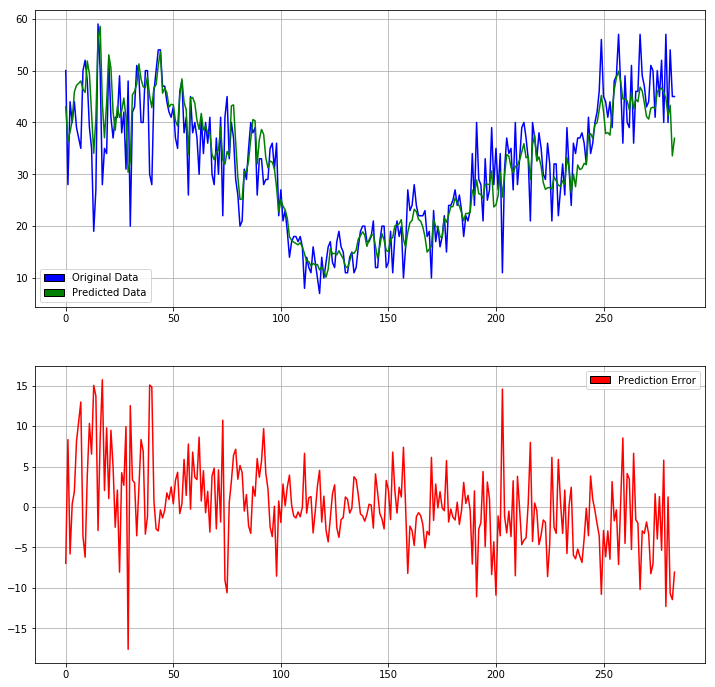

In [4]:
visualize.plot_model(X,y,model1)

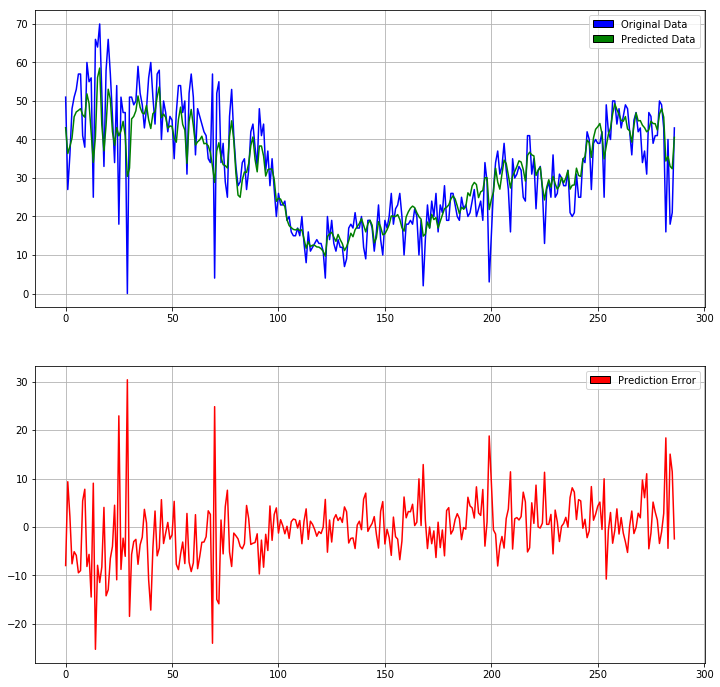

In [5]:
visualize.plot_model(X1,y1,model1)

With warm start, the first set of data seems to do better, but again lets score it

In [6]:
print "First set of data"
print "--------"
print "Score for test data : ",model1.score(X,y)
print "Score for training data : ",model1.score(X,y)
print "Mean absolute error of prediction : ",mean_absolute_error(y,model1.predict(X))
print "Mean square error of prediction : ",mean_squared_error(y,model.predict(X))
print "Mean square deviation of prediction : ",math.sqrt(mean_squared_error(y,model.predict(X)))
print ""
print "Second set of data"
print "--------"
print "Score for test data : ",model1.score(X1,y1)
print "Score for training data : ",model1.score(X1,y1)
print "Mean absolute error of prediction : ",mean_absolute_error(y1,model1.predict(X1))
print "Mean square error of prediction : ",mean_squared_error(y1,model.predict(X1))
print "Mean square deviation of prediction : ",math.sqrt(mean_squared_error(y1,model.predict(X1)))

First set of data
--------
Score for test data :  0.820880270559
Score for training data :  0.820880270559
Mean absolute error of prediction :  3.87588028169
Mean square error of prediction :  25.6036971831
Mean square deviation of prediction :  5.06000960306

Second set of data
--------
Score for test data :  0.802343540083
Score for training data :  0.802343540083
Mean absolute error of prediction :  4.56777003484
Mean square error of prediction :  102.524599303
Mean square deviation of prediction :  10.1254431658


Some of this error can be attributed to the fast that we are using data from all over the day - peak hours and non peak hours - when user behavior is different. Let's try some analysis limiting to the peak hours.

In [7]:
#def peak(h,m,w):
#    return 1 if ((w==1 and (h>=6 and (h <=9 and m<30)) or (h >= 18))) else 0

#def weekday(d):
#    dt=datetime.strptime(d,"%Y%m%d")
#    return 1 if datetime.isoweekday(dt)<6 else 0

#def get_weekday_data(date,dbname,lat,lon,high=0.9,low=0.1,start=0,end=24,holidays=[]):
#    if weekday(date)==0:
#        return None
#    df=taxis.getdf_loc_date(dbname,date,lat,lon)
#    h=df.quantile(q=high)['TaxiCount']
#    l=df.quantile(q=low)['TaxiCount']
#    df['Date']=date
#    df['Hour']=df.apply(lambda r:int(r['Time'][:2]),axis=1)
#    df['Minute']=df.apply(lambda r:int(r['Time'][2:]),axis=1)
#    df['Weekday']=df.apply(lambda r: weekday(r['Date']),axis=1)
#    df['Holiday']=df.apply(lambda r: 1 if r['Date'] in holidays else 0,axis=1)
#    df['PeakHour']=df.apply(lambda r: peak(r['Hour'],r['Minute'],r['Weekday']),axis=1)
#    df=df.query('(TaxiCount>=@l and TaxiCount<=@h) and (Hour>=@start and Hour<=@end)')[['Hour','Minute','PeakHour','TaxiCount']]
#    return df


In [8]:
def test_model(start_hour,end_hour):
    holidays=['20170626']
    lat1,lon1=utils.get_lat_long('Serangoon')
    dates=taxis.get_dates(DBNAME)
    data=[analysis.get_weekday_data(date,DBNAME,lat1,lon1,start=start_hour,end=end_hour,holidays=holidays) for date in dates]
    data=[x for x in data if x is not None]

    rf=RandomForestRegressor(n_estimators=100,n_jobs=10,warm_start=True)
    for df in data[:-1]:
        X=df.drop(['TaxiCount'],axis=1)
        y=np.array(df['TaxiCount'])
        rf.fit(X,y.ravel())
        rf.n_estimators+=20
        print rf.score(X,y)

    test=data[-1]

    Xt=test.drop(['TaxiCount'],axis=1)
    yt=np.array(test['TaxiCount'])

    visualize.plot_model(Xt,yt,rf)

from ipywidgets import interactive
import ipywidgets as widgets
interactive(test_model,start_hour=widgets.IntSlider(min=0,max=23,step=1,value=6,continuous_update=False),
            end_hour=widgets.IntSlider(min=0,max=23,step=1,value=10,continuous_update=False))